In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from tqdm.auto import tqdm
from skimage import io
from matplotlib.animation import FuncAnimation
from skimage.filters import gaussian

In [159]:
def showim(im_array, figsize=(4, 4), show_hist=False, nbins=None, bin_width=None, cmap='gray', vmin=None, vmax=None, titles=None):
    
    if isinstance(im_array, (list, tuple)):
        n_images = len(im_array)
        fig_width, fig_height = figsize
        plt.figure(figsize=(fig_width * n_images, fig_height))
        
        for idx, img in enumerate(im_array):
            plt.subplot(1, n_images, idx + 1)
            plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, (list, tuple)) and len(titles) == n_images:
                plt.title(titles[idx])
            elif titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        
        plt.show()
    else:
        plt.figure(figsize=figsize)
        
        if show_hist:
            plt.subplot(1, 2, 1)
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
            plt.subplot(1, 2, 2)
            
            im_flattened = im_array.ravel()
            min_val = np.floor(im_flattened.min())
            max_val = np.ceil(im_flattened.max())
            
            if bin_width is not None:
                bins = np.arange(min_val, max_val + bin_width, bin_width)
            elif nbins is not None:
                bins = nbins
            else:
                bins = int(max_val - min_val)
            
            plt.hist(im_flattened, bins=bins, color='black')
            plt.xlabel('Intensity Value')
            plt.ylabel('Frequency')
            plt.title('Image Intensity Histogram')
        
        else:
            plt.imshow(im_array, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def animate_stack(stack, fname = "animated_stack", fps = 10):
    fig, ax = plt.subplots()
    im = ax.imshow(stack[0], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')

    def update(frame):
        im.set_data(stack[frame])
        ax.set_title(f"Frame {frame}")
        return [im]

    ani = FuncAnimation(fig, update, frames=len(stack), interval=100, blit=True)
    plt.show()
    ani.save(f"{fname}.gif", writer="pillow", fps=fps)

def surfplot(imarr, figsize = (11,7), cmap = 'viridis', show = True):

    x = np.arange(imarr.shape[1])
    y = np.arange(imarr.shape[0])
    X , Y = np.meshgrid(x, y)

    if show == True:

        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, imarr, cmap=cmap)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Pixel Intensity')
        plt.show();


    return X , Y;



**A)** *Subtract  the  median  from  each  pixel  in  each  frame.  (Note: you  needn’t  loop  through  each  pixel!  Median  functions  can  act  on  a  specified  array dimension,  and  you  can  subtract  one  2D  array  from  another,  all  at  once.)  Submit  (i)  the median image, and (ii) a histogram of all the pixel values in the subtracted 3D image array.*

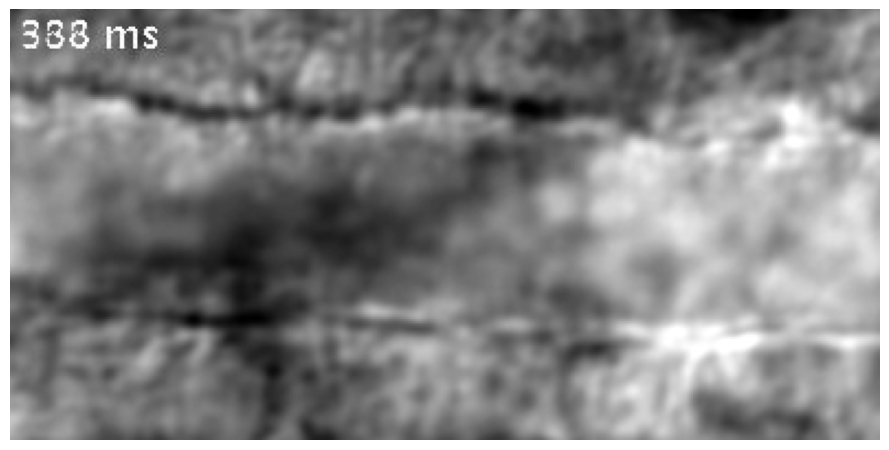

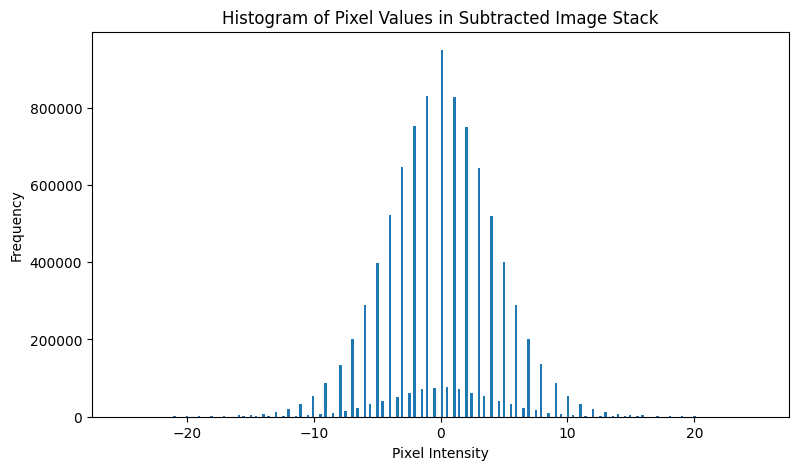

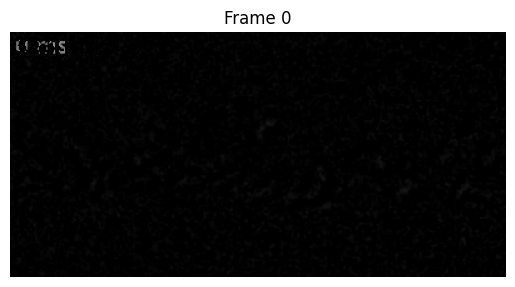

In [162]:
cilia = io.imread('/home/apd/Projects/ImageAnalysis/HW6/cilia_movie_crop.tif', plugin="tifffile")

median_cilia = np.median(cilia, axis=0)
subtracted_stack = cilia - median_cilia

showim(median_cilia, figsize=(9,5))

plt.figure(figsize=(9,5))
plt.hist(subtracted_stack.ravel(), bins=256, range=(-25, 25))
plt.title('Histogram of Pixel Values in Subtracted Image Stack')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

animate_stack(subtracted_stack, 'subtracted_stack', fps = 10)


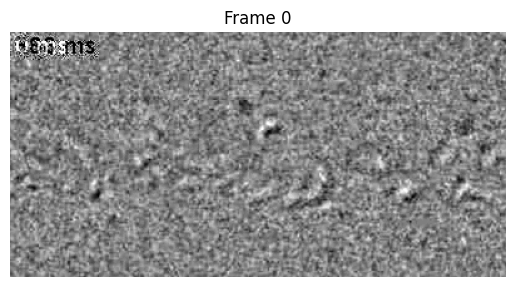

In [172]:
min_val, max_val = -20, 20
rescaled_stack = np.clip((subtracted_stack - min_val) * (255 / (max_val - min_val)), 0, 255).astype(np.uint8)
output_path = '/home/apd/Projects/ImageAnalysis/HW6/cilia_sub_rescaled_AidenDillon.tiff'
io.imsave(output_path, rescaled_stack, plugin='tifffile')
animate_stack(rescaled_stack, 'rescaled_stack')


**C)**

*Calculate  the  standard  deviation  of  each  (x,  y)  pixel  over  time,  creating  a  single  2D image  that  shows  this.  In  other  words,  pixel  intensity  [i,j]  of  the  2D  image  should  be  the standard deviation of the pixels intensities at position [i,j] in the 3D image series. Submit this image. (Hint: Making the array should be one line of code.)*

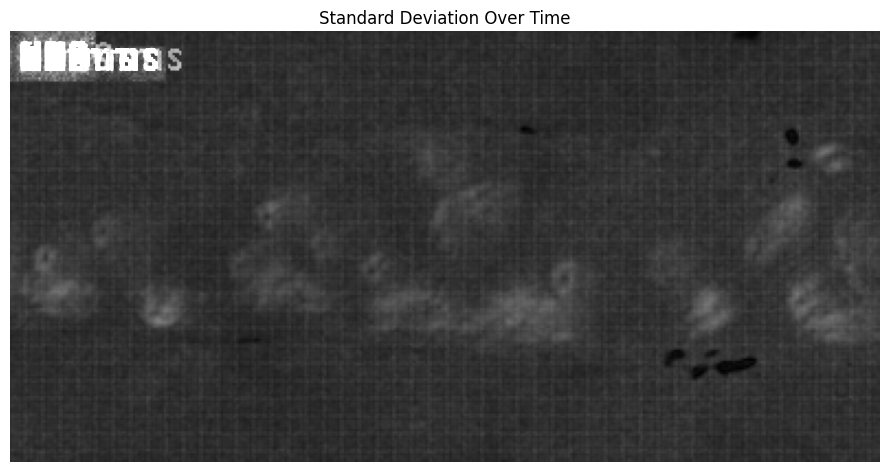

In [182]:
cilia_std = np.std(cilia, axis = 0)
showim(cilia_std,titles='Standard Deviation Over Time', figsize=(9,5), vmax = 20)

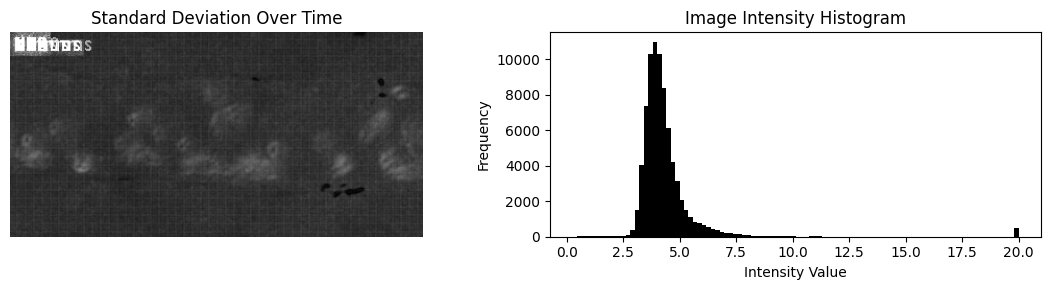

In [217]:
showim(np.clip(cilia_std,0,20), titles='Standard Deviation Over Time', figsize=(11,3), show_hist=True, nbins=100)

**D)** *Hopefully  from  watching  the  result  of  (a)  you  can  see  filament-like  things  are moving. Can you enhance this further? How could you weight different pixels differently, or  do some sort of averaging, or otherwise make things clearer? Think about this, play around with the arrays, and submit the best thing you can come up with as multipage TIFF image, along with a short description. Obviously, there is no “correct answer.*

In [296]:
def subtract_moving_average(stack, window_size=3):

    if window_size % 2 == 0:
        raise ValueError("Window size should be odd.")
        
    pad_width = window_size // 2
    padded_stack = np.pad(stack, ((pad_width, pad_width), (0, 0), (0, 0)), mode='reflect')

    result_stack = np.empty_like(stack)

    for t in range(stack.shape[0]):
        moving_average = np.mean(padded_stack[t:t + window_size], axis=0)
        result_stack[t] = moving_average
    
    return result_stack

In [ ]:
def subtract_moving_average_conditional(stack, window_size=3, std_dev_threshold=10):
    std_dev_map = np.std(stack, axis=0)
    
    low_variability_mask = std_dev_map < std_dev_threshold

    pad_width = window_size // 2
    padded_stack = np.pad(stack, ((pad_width, pad_width), (0, 0), (0, 0)), mode='reflect')
    
    result_stack = np.empty_like(stack)
    
    for t in range(stack.shape[0]):
        
        moving_average = np.mean(padded_stack[t:t + window_size], axis=0).astype(np.uint8)
        result_stack[t] = stack[t]
        result_stack[t][low_variability_mask] = moving_average[low_variability_mask]
    
    return result_stack

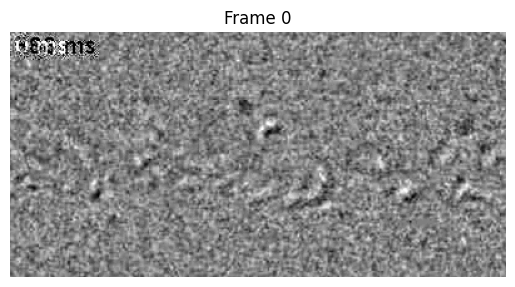

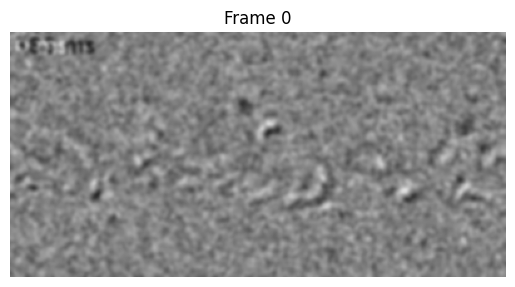

In [ ]:
window_size = 11  
moving_average_conditional= subtract_moving_average_conditional(rescaled_stack, window_size=window_size, std_dev_threshold=3)
animate_stack(moving_average_conditional, 'moving_avg_conditional')
low_pass_moving_avg = np.array([(gaussian(frame, sigma=1.5)*255).astype(np.uint8) for frame in moving_average_conditional])
animate_stack(low_pass_moving_avg, 'moving_avg_conditional_lowpass')

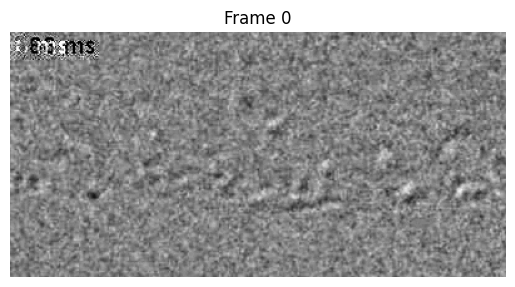

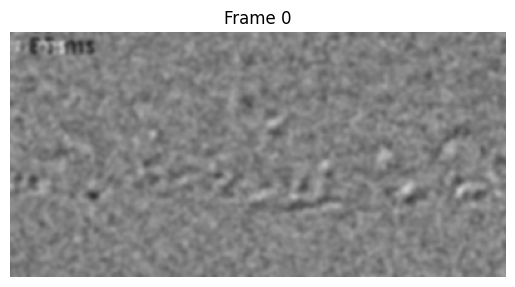

In [ ]:
window_size = 3  
moving_average = subtract_moving_average(rescaled_stack, window_size=window_size)
animate_stack(moving_average, 'moving_avg')
low_pass_moving_avg = np.array([(gaussian(frame, sigma=1.5)*255).astype(np.uint8) for frame in moving_average])
animate_stack(low_pass_moving_avg, 'moving_avg_lowpass')

**(Official Attempt)**

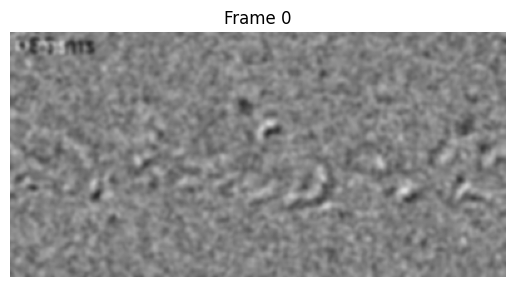

In [297]:
low_pass_stack = np.array([(gaussian(frame, sigma=1.5)*255).astype(np.uint8) for frame in rescaled_stack])
animate_stack(low_pass_stack, "low_pass_stack")
output_path = '/home/apd/Projects/ImageAnalysis/HW6/Problem_1D_AidenDillon.tiff'
io.imsave(output_path, rescaled_stack, plugin='tifffile')

The best method I could come up with, without compeltely obfuscating the movement/shape of the cilia, was a simple gaussian filter. I did attempt setting the pixels as their moving average depending on their std deviation, since pixels with higher standard deviations more likely correlate to movement and thus we could average out the noisy non-cilia pixels. However, the main issue isn't the surrounding pixels but the pixels within the path of the moving cilia, (ones with high std dev). Maybe some logic could be done such as edge detection or checking how quickly the pixel value has changed with respect to time (i.e. within the past nstacks) and make that binarize the image by such a intensity rate of change threshold. I attempted something like it but I think that just takes a lot of fine-tuning for it to be successful, see my attempts below.

(126, 196, 396)


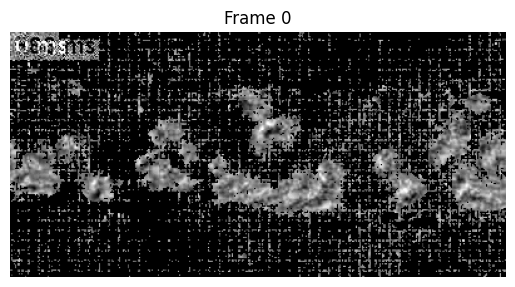

In [281]:
def binary_mask_per_frame(stack, threshold):
    std_dev_map = np.std(stack, axis=0)
    mask = (std_dev_map > threshold).astype(np.uint8)
    binary_mask_stack = stack * mask
    
    return binary_mask_stack

threshold = 28

binary_mask = binary_mask_per_frame(rescaled_stack, threshold)
print(binary_mask.shape)


animate_stack(binary_mask)

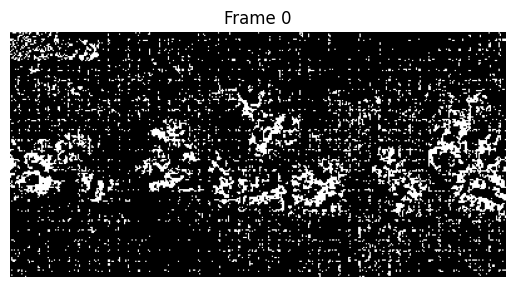

In [295]:

def compute_rate_of_change(stack, nstacks=3, threshold=None, upper_bound=255):

    diff_stack = np.abs(np.diff(stack, axis=0).astype(np.float64))
    rate_of_change = np.zeros_like(stack[:-nstacks + 1], dtype=np.float64)

    for i in range(nstacks - 1):
        rate_of_change += diff_stack[i:stack.shape[0] - nstacks + 1 + i]

    rate_of_change /= (nstacks - 1.0)

    if threshold is not None:
        output1 = (rate_of_change > threshold).astype(np.uint8)
        output2 = (rate_of_change < upper_bound).astype(np.uint8)
        output = (output1 & output2) 
    else: 
        output = rate_of_change.astype(np.uint8)
    
    return output

bin_stack = compute_rate_of_change(binary_mask, nstacks=2, threshold=0, upper_bound=100)*255
animate_stack(bin_stack)


**D)** *Do the cilia look like they are moving “back and forth” with the same form, or not? (In  other  words,  does  the  shape  of  a  cilium  look  the  same  on  the  forward  and  reverse stroke?  Does  the  movie  look  the  same  if  played  forward  and  backward?)  I  found  a  region near the center to be clearest to see this. Answer as best you can -- showing some snapshots might help, but you don't have to*. 

The cilia do look like they are moving back and forth with the same form, with the shape being the same on the forward and backwawrd stroke.

Problem 2

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

N = 20
x = np.linspace(-3, 4, N)
x_true, b_true = 0.75, 2.2
A = 3 * np.abs(x - x_true) ** b_true + 4
y = np.random.poisson(A)

def objective(params, x, y):
    x0, b = params
    A_model = 3 * np.abs(x - x0) ** b + 4
    return np.sum(A_model - y * np.log(A_model))

initial_guess = [1.0, 2]  
result = minimize(objective, initial_guess, args=(x, y), bounds=((0, None), (0, None)))
x0_est, b_est = result.x

print(f'Estimated x0: {x0_est}, Estimated b: {b_est}')


Estimated x0: 0.7970237011799536, Estimated b: 2.2759347641051666


**B)** *How close are the estimated $x_0$ and b to the true values? Run your code a few times, and “by eye” comment on the accuracy. (Or if you want, run it a lot and calculate the RMSE.)*

The values are very similar to the original (true) values used to generate the data, indicating good performance of the MLE.

Plot the simulated y vs. x datapoints together with the function $3|x-x_0|b +4$ for both the true and estimated parameter values. Submit the plot.

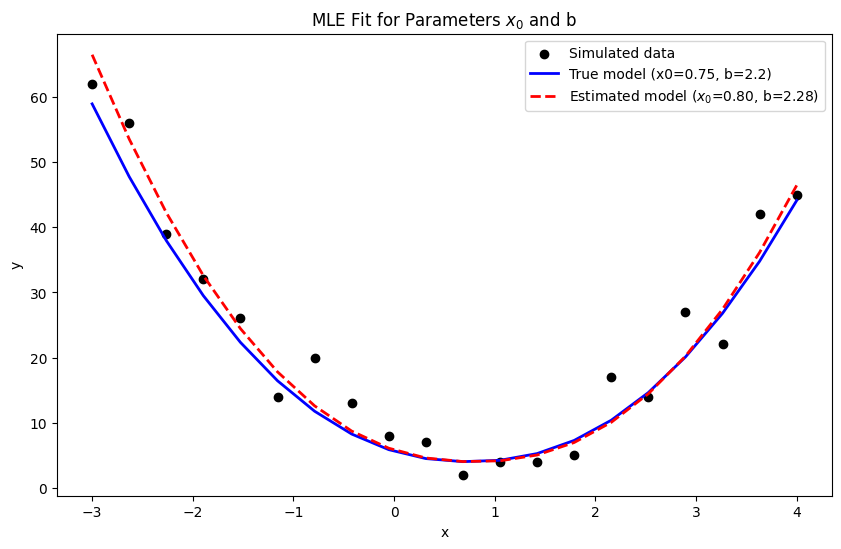

In [312]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Simulated data", color='black')
plt.plot(x, A, label=f"True model (x0={x_true}, b={b_true})", color='blue', linewidth=2)
A_est = 3 * np.abs(x - x0_est) ** b_est + 4

plt.plot(x, A_est, label=f"Estimated model ($x_0$={x0_est:.2f}, b={b_est:.2f})", color='red', linestyle='--', linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("MLE Fit for Parameters $x_0$ and b")
plt.show()

**D)** *Calculate the objective function for a grid of parameter values x0 = 0.1 to 10 in steps of 0.1, and b = 0.1 to 10 in steps of 0.1. Submit a plot of this  – it could be a surface plot, or a 2D plot with color indicating the value of the objective function.*

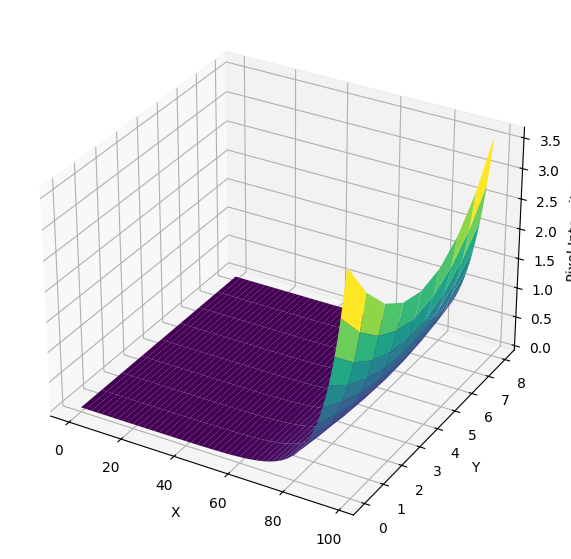

In [314]:
x0_vals = np.arange(0.1, 1.0, 0.1)
b_vals = np.arange(0.1, 10, 0.1)
objective_grid = np.zeros((len(x0_vals), len(b_vals)))

for i, x0 in enumerate(x0_vals):
    for j, b in enumerate(b_vals):
        objective_grid[i, j] = objective([x0, b], x, y)

surfplot(objective_grid);


**3 Centroid localization timing. (2 pts.)** 

Re-run your center-of-mass (centroid) localization code on 
simulated 2D single-molecule  images as in Homework  5. Use the parameters described above, and 
have the true positions be random numbers between -0.05 μm and 0.05 μm in x and y. Assess how 
long  per  image  the  centroid  localization  takes  –  in  other  words,  simulate  M  images  and  note  total 
time / M. (Note the timing functions we used in HW3) Note that you should not include the time 
needed  to  create  the  simulated  images.  First  create  a  (3D)  array  of  simulated  images  and  then  loop 
through these, running your centroid localization function on each “slice.” Submit one number: the 
centroid computation time per image.

• 7 × 7 px images with scale = 100 nm/px (i.e. 0.1 μm/px), λ = 510 nm, NA = 0.9 

• Number of photons = 1000 

• M = 100 simulated images for each condition

In [315]:
def calculate_centroid(intensities, camera_scale = None, origin_center=False):
    """
    Calculate the centroid (center of mass) for 1D or 2D intensity arrays,
    with an option to shift the origin to the center of the array.

    Parameters:
    intensities (np.array): Array of intensity values, either 1D or 2D.
    origin_center (bool): If True, shifts the origin to the center of the array.
                          If False, uses the bottom-left corner as the origin.

    Returns:
    tuple: The centroid position. For 1D, returns (x_centroid,).
           For 2D, returns (x_centroid, y_centroid).
    """
    if intensities.ndim == 1:
        # 1D case
        n = len(intensities)
        positions = np.arange(n)
        if origin_center:
            center = (n - 1) / 2
            positions = positions - center  
        x_centroid = np.sum(positions * intensities) / np.sum(intensities)
        if camera_scale:
            return x_centroid*camera_scale
        else:
            return x_centroid
    
    elif intensities.ndim == 2:
        # 2D case
        m, n = intensities.shape
        x_positions = np.arange(n)
        y_positions = np.arange(m)
        
        if origin_center:
            x_center = (n - 1) / 2
            y_center = (m - 1) / 2
            x_positions = x_positions - x_center 
            y_positions = y_positions - y_center  
        
        x_weights = np.sum(intensities, axis=0)  
        y_weights = np.sum(intensities, axis=1)  
        
        x_centroid = np.sum(x_positions * x_weights) / np.sum(intensities)
        y_centroid = np.sum(y_positions * y_weights) / np.sum(intensities)
        
        if camera_scale:
            return (x_centroid*camera_scale, y_centroid*camera_scale)
        else:
            return (x_centroid, y_centroid)

    else:
        raise ValueError("Only 1D and 2D arrays are supported")


def sim_ps(N_camera, wavelength, NA, camera_scale, fine_scale, N_photon, center = None, B = None):
    block_size = int(camera_scale / fine_scale)
    fine_grid_N = N_camera * block_size
    
    x = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    y = np.linspace(-fine_grid_N//2, fine_grid_N//2, fine_grid_N) * fine_scale
    X, Y = np.meshgrid(x, y)
    if center:
        xc, yc = center
    else: xc, yc = 0, 0

    r = np.sqrt((X - xc)**2 + (Y - yc)**2)
    
    v = (2 * np.pi / wavelength) * NA * r
    
    psf_fine = np.zeros_like(v)
    psf_fine[v == 0] = 1
    psf_fine[v != 0] = 4 * (j1(v[v != 0]) / v[v != 0])**2
    
    psf_fine = psf_fine / psf_fine.sum()
    
    psf_camera = np.zeros((N_camera, N_camera))

    for i in range(N_camera):
        for j in range(N_camera):
            block = psf_fine[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            psf_camera[i, j] = np.sum(block)
    
    psf_camera /= np.sum(psf_camera)
    
    psf_camera *= N_photon
    
    noisy_psf = np.random.poisson(psf_camera)

    background = np.random.poisson(B, (N_camera, N_camera))

    final_image = noisy_psf + background

    
    return final_image

In [316]:
import time

N_camera = 7
wavelength = 0.51
NA = 0.9
camera_scale = 0.1 
fine_scale = 0.01
N_photons = 1000
bg = 2

M = 100

ps_stack = []

for _ in range(M):

    center_x = np.random.uniform(-0.05,0.05)
    center_y = np.random.uniform(-0.05,0.05)
    center = (center_x,center_y)
    new_ps = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
              fine_scale=fine_scale, N_photon=N_photons, center = center, B=bg)
    ps_stack.append(new_ps)

ps_stack = np.array(ps_stack)
print(ps_stack.shape)

start_time = time.time()

for i in range(M):
    calculate_centroid(ps_stack[i], camera_scale=camera_scale, origin_center=True)
    
end_time = time.time()


print(f"Average time per centroid calculation: {(end_time-start_time)/M:.6f} seconds")


(100, 7, 7)
Average time per centroid calculation: 0.000040 seconds


**4  Gaussian  MLE  for  particle  localization!  (14  pts.)** 

Write  a  2D  MLE  particle  localization function! In other words, write a function that returns the MLE estimate for the particle center (xc, 
yc)  and  other  parameters  given  a  2D  image  in  which  each  pixel  has  Poisson-distributed  random 
values with a mean that depends on position as: 

$$𝐴(𝑥,𝑦)=𝐴_0 𝑒𝑥𝑝[−\frac{(𝑥−𝑥𝑐)^2 +(𝑦−𝑦𝑐)^2}{2𝜎^2}] + 𝐵 $$

(In other words, a Gaussian  approximation to the PSF.)  Then apply Gaussian MLE localization to 
the same sorts of simulated images that you used earlier. 

In [155]:
def calculate_MLE(intensities, initial_guess, camera_scale=0.01, origin_center=True):
    N = intensities.shape[0]
    x = np.arange(N)
    y = np.arange(N)
    
    if origin_center==True:
        x = x - (N - 1) / 2
        y = y - (N - 1) / 2
    
    X, Y = np.meshgrid(x, y)

    def objective(params, X, Y, data):
        xc, yc, A0, sigma, B = params
        model = A0 * np.exp(-((X - xc)**2 + (Y - yc)**2) / (2 * sigma**2)) + B
        return np.sum(model - data * np.log(np.where(model > 0, model, 1)))

    results = minimize(objective, initial_guess, args=(X, Y, intensities))
    xc_est, yc_est, A0_est, sigma_est, B_est = results.x

    if camera_scale:
        xc_est *= camera_scale
        yc_est *= camera_scale

    return xc_est, yc_est, A0_est, sigma_est, B_est

**B)** *Repeat #3, now using MLE localization. Time how long per image it takes.*

In [150]:
#xc_est, yc_est, A0_est, sigma_est, B_est

initial_guess = [0,0,100,1,0]

start_time = time.time()

for i in range(M):
    
    calculate_MLE(ps_stack[i], initial_guess=initial_guess, camera_scale=camera_scale, origin_center=True)
    
end_time = time.time()


print(f"Average time per centroid calculation: {(end_time-start_time)/M:.6f} seconds")

Average time per centroid calculation: 0.007541 seconds


The MLE certainly takes longer than the centroid calculation, which makes sense. We are doing a minimization problem which involves many more operations (and overhead using imported libraries) in addition to now "finding" 5 parameters instead of the 2 in the centroid calculation

**C)** *Repeat  HW5  #3c,  now  using  MLE  localization,  making histograms for:* 

*Nphotons = 1000, (x0, y0) = (0.0, 0.0) px, (x0, y0) = (0.3, 0.0) px, and (x0, y0) = (-0.3,  0.0)  px.* 

***Does  the  MLE  estimate  look  unbiased?*** 

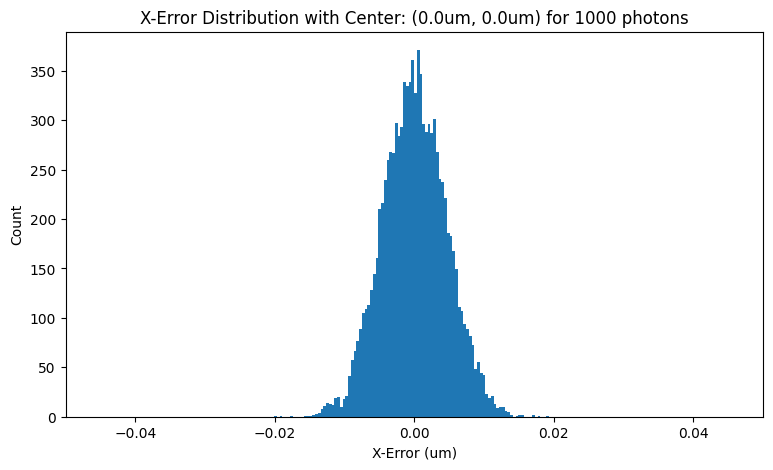

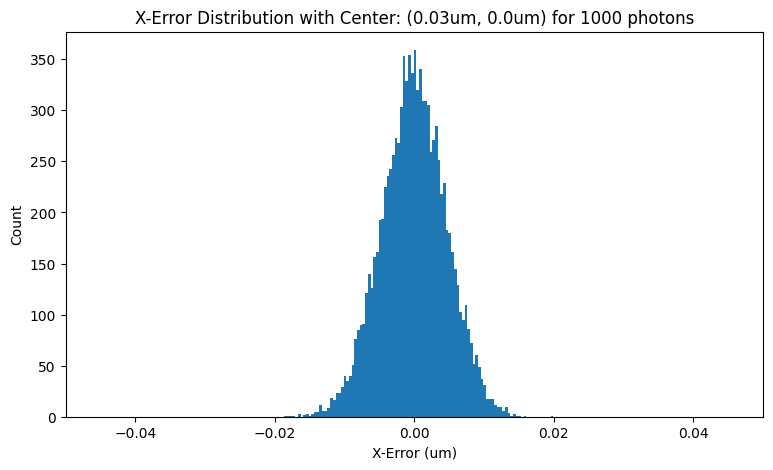

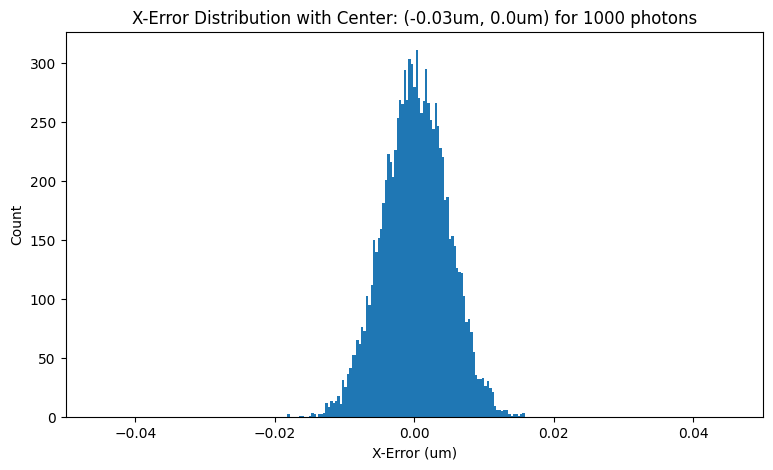

In [158]:
N_camera = 7
wavelength = 0.510
NA = 0.9
N_photons = 1000
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 10000
center_list = [(0.0, 0.0), (0.03, 0.0), (-0.03, 0.0)]

for center in center_list:

    x_error_list = []
    current_center = center

    for i in range(m):

        image = image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                fine_scale=fine_scale, N_photon=N_photons, center=current_center, B=bg)
        
        MLE = calculate_MLE(image, initial_guess=initial_guess, camera_scale=camera_scale, origin_center=True)
        x_MLE = MLE[0]
        x_error = x_MLE - center[0]

        x_error_list.append(x_error)

    plt.figure(figsize=(9,5))
    plt.hist(x_error_list, bins=100)
    plt.xlim(-0.05, 0.05)
    plt.xlabel('X-Error (um)')
    plt.ylabel('Count')
    plt.title(f"X-Error Distribution with Center: ({center[0]}um, {center[1]}um) for {N_photons} photons");

The MLE does indeed look unbaised! The distribution of error is comparable in all three of these cases, indicating an unbiased method for finding the center of the point source.

Outer Loop, X Center = -0.0400 :   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for -0.0500:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for -0.0400:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for -0.0300:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for -0.0200:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for -0.0100:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0000:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0100:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0200:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0300:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0400:   0%|          | 0/11 [00:00<?, ?it/s]

Processing Y positions for 0.0500:   0%|          | 0/11 [00:00<?, ?it/s]

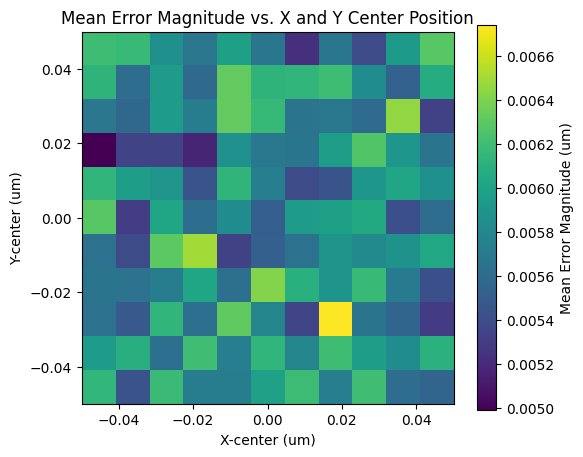

In [157]:
N_camera = 7
wavelength = 0.510
NA = 0.9
N_photons = 1000
camera_scale = 0.1
fine_scale = 0.001
bg = 10

m = 100

center_x_list = np.linspace(-0.05, 0.05, 11)
center_y_list = np.linspace(-0.05, 0.05, 11)

mean_error_magnitude_array = np.zeros((len(center_x_list), len(center_y_list)))

for i, center_x in tqdm(enumerate(center_x_list), total = len(center_x_list), desc = f"Outer Loop, X Center = {center_x:.4f} ", leave=False):
    for j, center_y in tqdm(enumerate(center_y_list), total=len(center_y_list), 
                             desc=f"Processing Y positions for {center_x:.4f}", leave=False):

        current_center = (center_x, center_y)
        
        error_magnitude_list = []

        for _ in range(m):
            image = sim_ps(N_camera=N_camera, wavelength=wavelength, NA=NA, camera_scale=camera_scale, 
                           fine_scale=fine_scale, N_photon=N_photons, center=current_center, B=bg)

            MLE = calculate_MLE(image, initial_guess=initial_guess, origin_center=True, camera_scale=camera_scale)
            x_MLE, y_MLE = MLE[0], MLE[1]

            error_magnitude = np.sqrt((x_MLE - center_x) ** 2 + (y_MLE - center_y) ** 2)
            error_magnitude_list.append(error_magnitude)

        mean_error_magnitude_array[i, j] = np.mean(error_magnitude_list)

plt.figure(figsize=(6, 5))
c = plt.imshow(mean_error_magnitude_array, extent=[center_x_list[0], center_x_list[-1], center_y_list[0], center_y_list[-1]], 
                cmap='viridis')
plt.colorbar(c, label="Mean Error Magnitude (um)")
plt.title("Mean Error Magnitude vs. X and Y Center Position")
plt.xlabel("X-center (um)")
plt.ylabel("Y-center (um)")
plt.show()

It seems like the error no longer depends on the position, which is great! We want methods that have similar (or unbiased) errors and error distributions independent of the true value, which seems to be what this MLE does.